In [5]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import convolve
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
import astropy.units as u

# constants
day_in_hz = 1.15740741e-5 
day_in_s = 86400
hz_to_days = day_in_s


data_file01 = 'tess_lc1.dat'
data_file02 = 'tess_lc2.dat'

In [15]:
# functions

def get_data(data_file):
    '''Reads in exoplanet data from the data file, removes nan values
       and normalizes flux (so the average is 1). 
       
       Returns a 2D data array, where data[:,0] is time, and data[:,1] is the flux measurements
       '''
    data = np.genfromtxt(data_file)
    # Remove NaN values from the data array
    data = data[~np.isnan(data).any(axis=1)]
    # normalize data
    data[:,1] = data[:,1]/np.nanmean(data[:,1]) 
    return data


def normalized_boxcar_convolve(signal, boxcar_length):
    ''''A function that smoothes data by a using a normalized boxcar convolution,
    returned array is the same length as the inputted array.
    '''
    # Create a boxcar kernel of the specified length
    boxcar_kernel = np.ones(boxcar_length) / boxcar_length
    # Perform convolution
    convolved_signal = convolve(signal, boxcar_kernel, mode='same')
    return convolved_signal


def find_nearest(array, value):
    '''Finds the nearest specified value in an array, and returns its index'''
    idx = (np.abs(array - value)).argmin()
    return idx


def fundemental_freq_model(n_peaks, f0,c ):
    '''A linear model for finding N frequency harmonics. 
       n_peaks, are the identified harmonic frequencies (in order) from data, 
       f0 is is the fundemental frequency. C is a constant'''
    return (np.arange(len(n_peaks)) + 1)*f0 +c



def find_period(data, smoothed_data, boxcar_length, make_plot = True, exoplanet_name = '',
                n=10000, f_min = 1/(2*720), f_max = 4):
    '''Finds the period of a exoplanet orbit (in days), from exoplanet data. Works by using the 
    smoothed_data to make a lomscargle period-o-gram, from there it identifies harmonic frequencies
    and performs a fitting for the fundemental frequency (which is then converted to a period)
    
    Optionally creates a LombScargle period-o-gram and identifies the frequency peaks.

    Args:

    data: 2d numpy array
          a 2D data array, where data[:,0] is time, and data[:,1] is the flux measurements
    
    smoothed_data: 1d numpy array
                   smoothed flux measurements of data[:,1], IE smoothed by 'normalized_boxcar_convolve'

    boxcar_length: int
                   length of boxcar used for smoothing

    Optional Args:

    make_plot: bool, default True
               if True, makes plots
    
    exoplanet_name: str, default = ''
                    name of exoplanet for plot title

    n: int, default = 1000
       number of frequency values to search over
    
    f_min: float, default = 1/(2*720), units are 1/days
           min frequency value to search over

    f_max: float, default =4, units are 1/days
           min frequency value to search over

    Returns: period of exoplanet, in days
    '''

    sample_times = data[boxcar_length:-boxcar_length,0]
    time = sample_times
    flux_values = smoothed_data[boxcar_length:-boxcar_length] / np.nanmean(data[:,1])
    y = flux_values 

    # make lombscargle period-o-gram
    f = np.linspace(f_min, f_max,  n) * day_in_hz * u.Hz
    power = LombScargle(time * u.day, y).power(frequency=f)

    frequency = f / u.Hz
    # identify peaks
    peaks, _ = find_peaks(power,height=0.03)

    if make_plot == True:
        if exoplanet_name != '':
            exoplanet_name += '\n'
        plt.figure(figsize=(12,6))
        plt.plot(frequency * day_in_s, power, label="Power Spectrum", color='firebrick')
        plt.title(exoplanet_name + 'Lomb-Scargle periodogram', size=15)
        plt.xlabel('Frequency (1/Days)', size=15)
        plt.ylabel('Power Spectrum', size=15)
        plt.plot(frequency[peaks] * day_in_s, power[peaks], "x", color='k', label='Identified Peaks')
        plt.legend(fontsize=15)

    # perform fitting to identify fundemental frequency
    fundemental_freq = frequency[peaks]  / u.Hz
    popt, pcov = curve_fit(fundemental_freq_model, xdata =peaks, ydata=(f[peaks])*day_in_s)

    f0 = popt[0] # the inverse of f0 is period, units are days
    return 1/f0


def phase_plot(x, y, period, make_plot=True, exoplanet_name = ''):
    '''Create phase-folded lightcurve of input time-series,
    returns phase-folded lightcurve. Rolls the returned lighcurve
    so that the minimum is in the middle.

    Optionally plots the outputs.


    modifed version of this (from 8:06)
    https://www.youtube.com/watch?v=2EwtD3Nhazs&t=2859s&ab_channel=LSSTCDataScienceFellowship
    
    Args:
    x: ndarray
       time-like values

    y: ndarray
       flux like values

    period: float
            period to fold the data

    Optional Args:

    make_plot: bool, default True
               if True, makes plots
    
    exoplanet_name: str, default = ''
                    name of exoplanet for plot title

    Returns:
    new_x, new_y: arrays corresponding to the folded lightcurve. 
                  new_x is time-like but only for a single period
                  new_y is flux like
    '''

    # folding lightcurve
    phases = (x/period) % 1
    plot_order = np.argsort(phases)
    new_x = phases[plot_order]
    new_y = y[plot_order]

    # roll so min is in middle
    min_index = np.argmin(new_y)
    n = len(new_y) // 2 - min_index
    new_y = np.roll(new_y, n)

    # make plot
    if make_plot == True:
      if exoplanet_name != '':
          exoplanet_name += '\n'
      plt.figure(figsize=(12,6))
      plt.ylabel("Relative Flux", size=15)
      plt.xlabel('Phase', size=15)
      plt.title(exoplanet_name + 'Folded Exoplanet Lightcurve', size=15)
      plt.scatter(new_x, new_y, linewidth=0.5, color='k', label='Data')
      plt.legend(fontsize=15)
      plt.show()

    return new_x, new_y



def transit_model(time, t_cent, dt_total, flux_avg, depth, dt_in):
    '''A modified boxcar model for an exoplanet transit. 
    
       Model works by assuming constant (flux_avg) of the star before the transit
       during the transit, it dips to flux_avg - depth. During the ingress, and egress
       limb darkening is aproximated to be linear with time. Ingress & Eggress are 
       assumed to take the same amount of time. 
       
       
       Args:
       time: float, numpy array
       
       t_cent: float
               center of exoplanet transit time
               
       dt_toal: float
                length of exoplanet transit excluding inggress & eggress
        
       flux_avg: float
                 flux of the star when exoplanet is not transiting
                 
        depth: float
               depth of exoplanet on dip lightcurve 
               
        dt_in: float
               length of eggres & inggres time
               
        Returns: float, numpy array
                 model lightcurve flux
        '''

    # start as all flux_avg
    lightcurve = np.ones(len(time)) * flux_avg

    # make top hat part
    start_idx = find_nearest(time, t_cent - 0.5*dt_total)
    end_idx = find_nearest(time, t_cent + 0.5*dt_total)
    lightcurve[start_idx:end_idx] = (flux_avg - depth)


    # ingress part 
    slope = ((flux_avg- depth)  - flux_avg)/ dt_in
    start_in_idx = find_nearest(time, t_cent - 0.5*dt_total - dt_in)
    end_in_idx = find_nearest(time, t_cent  - 0.5*dt_total)
    ingress_len = len(lightcurve[start_in_idx:end_in_idx])
    slope = ((flux_avg- depth)  - flux_avg) / ingress_len
    lightcurve[start_in_idx:end_in_idx] = slope* np.arange(ingress_len) + flux_avg

    # egress
    start_eg_idx = find_nearest(time, t_cent + 0.5*dt_total)
    end_eg_idx = find_nearest(time, t_cent + 0.5*dt_total +dt_in)
    eggress_len = len(lightcurve[start_eg_idx:end_eg_idx])
    slope = ((flux_avg - (flux_avg- depth))) / eggress_len
    lightcurve[start_eg_idx:end_eg_idx] = slope* np.arange(eggress_len) + (flux_avg - depth)

    return lightcurve


def fit_transit_model(time, lightcurve, initial_guess=None, absolute_sigma=True, sigma=None):
    '''Performs fitting of the 'transit_model' function and returns the assiocaited popt, pcov from scipy.curve_fit.
       See the curve_fit documentation for information on initial_guess(=p0), and other optional args'''
    popt, pcov = curve_fit(transit_model, time, lightcurve, p0=initial_guess, absolute_sigma=True, sigma=None)
    return popt, pcov



def plot_raw_lc(data_file, boxcar_length, make_plot=True, exoplanet_name=''):
    '''reads in, and smoothes (via boxcar convolution) lightcurve data
       optionally produces a plot. Returns normalized exoplanet data,
       and normalized & smoothed flux values'''
    data = get_data(data_file01)
    #boxcar_length = 20
    smoothed_data = normalized_boxcar_convolve(signal=data[:,1], boxcar_length=boxcar_length)
    if make_plot == True:
        if exoplanet_name != '':
            exoplanet_name += '\n'
        plt.figure(figsize=(12,6))
        plt.scatter(data[:,0], data[:,1]/ np.nanmean(data[:,1]), linewidth=0.5, color='k', label='Data',  alpha=0.5)
        plt.plot(data[boxcar_length:-boxcar_length,0], smoothed_data[boxcar_length:-boxcar_length]/ np.nanmean(data[:,1]), 
                 linewidth=2, color='Green', label='Smoothing = ' + str(boxcar_length),)
        plt.ylabel("Relative Flux", size=15)
        plt.xlabel('Julian Date – 2457000', size=15)
        plt.title(exoplanet_name + 'Exoplanet Lightcurve', size=15)
        plt.legend(fontsize=15)
        #plt.ylim(0.993, 1.004)
        plt.show()

    return data, smoothed_data






In [21]:
def fit_and_plot_transit(time, lightcurve_data, boxcar_length, period, make_plot=True, exoplanet_name=''):
    '''Fits exoplanet data to model, plots and returns period, popt, pcov.
       Fits to the unsmoothed data'''
   
    # for model fitting, look between 0.4 and 0.6 of the phase
    start_idx = find_nearest(time, 0.4)
    end_idx = find_nearest(time, 0.6)
    time = time[start_idx:end_idx]
    lightcurve_data = lightcurve_data[start_idx:end_idx]

    # make smoothed data
    smoothed_flux_data_folded = normalized_boxcar_convolve(signal=lightcurve_data, boxcar_length=boxcar_length)
    smoothed_time_folded = time[boxcar_length:-boxcar_length]
    smoothed_flux_data_folded = smoothed_flux_data_folded[boxcar_length:-boxcar_length]

    # perform model fitting
    #t_cent, dt_total, flux_avg, depth, dt_in
    initial_guess = [0.505, .15/period, 1, 0.0035, 0.01]
    popt, pcov = fit_transit_model(time, lightcurve=lightcurve_data, initial_guess=initial_guess, absolute_sigma=True, sigma=None)

    if make_plot == True:
        if exoplanet_name != '':
            exoplanet_name += '\n'
        plt.figure(figsize=(12,6))
        plt.scatter(time, lightcurve_data, linewidth=0.5, color='k', label='Data', zorder=0, alpha=0.5)
        plt.ylabel("Relative Flux", size=15)
        plt.xlabel('Phase', size=15)
        plt.plot(smoothed_time_folded, smoothed_flux_data_folded, linewidth=3, color='green', label='Smoothing = ' + str(boxcar_length), zorder=0)
        plt.plot(time, transit_model(time, *popt), linestyle='--', color='magenta', label='\'Advanced\' Transit Model', zorder=1,linewidth=3)
        plt.title(exoplanet_name + 'Folded Exoplanet Lightcurve', size=15)
        legend = plt.legend(fontsize=15, loc='lower left',title='Period = ' + str(period)[0:4] + ' (Days)') 
        legend.get_title().set_fontsize(15)
        plt.xlim(.4,.6)
        
    return period, popt, pcov


def find_exoplanet(data_file, boxcar_length, make_plot=True,):
    '''Performs 'full' set of analysis on a given exoplanet data file. Plots are optional
    Smoothes data, and plots full lightcurve. Then produces a LombScargle period-o-gram, 
    and identifies the period of the exoplanet in Days makes plot of period-o-gram. Then it folds 
    the exoplanet lightcurve to overlay all transits together, and fits the data to a model.
    
    Returns period, popt, pcov.'''

    data, smoothed_data = plot_raw_lc(data_file=data_file, boxcar_length=boxcar_length, exoplanet_name=data_file)
    period = find_period(data, smoothed_data, boxcar_length, make_plot = make_plot, exoplanet_name=data_file)
    time_folded, flux_data_folded = phase_plot(x=data[:,0], y=data[:,1], period=period, make_plot=False, exoplanet_name=data_file)
    period, popt, pcov = fit_and_plot_transit(time_folded, flux_data_folded, boxcar_length, period, make_plot=make_plot, exoplanet_name=data_file)

    return period, popt, pcov
    

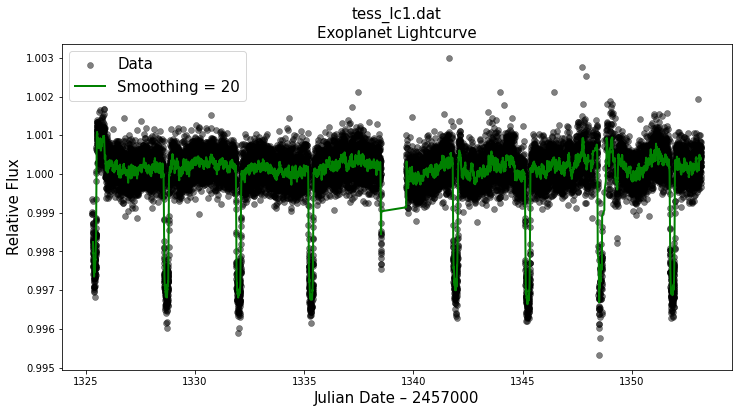

/home/afinemax/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


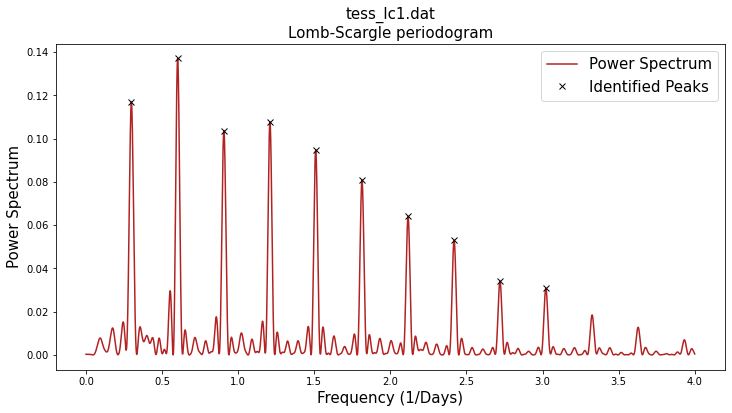

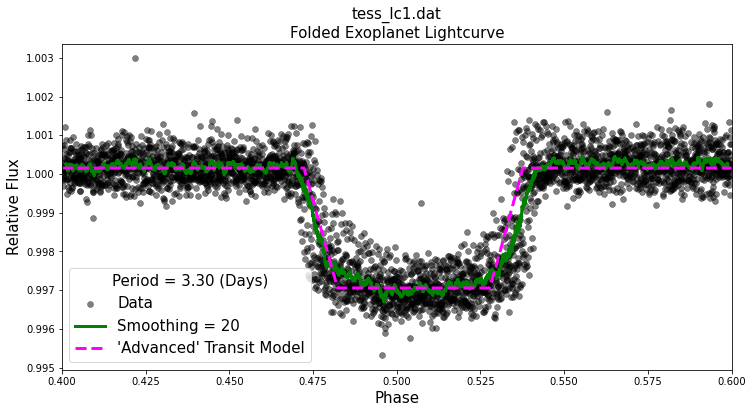

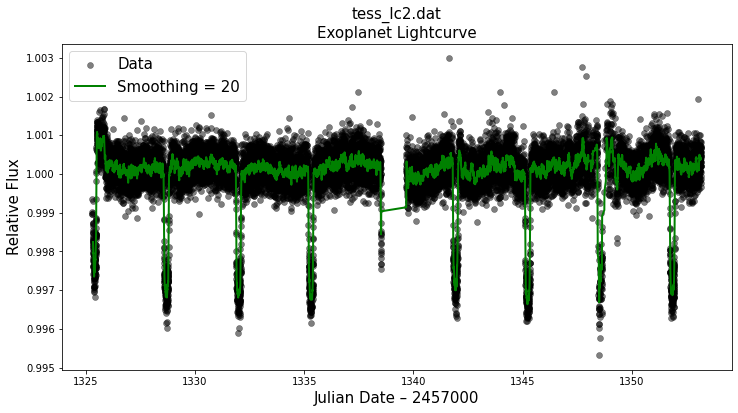

/home/afinemax/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


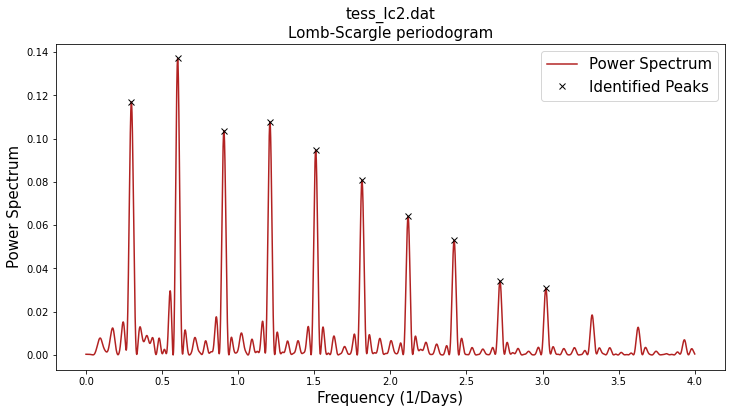

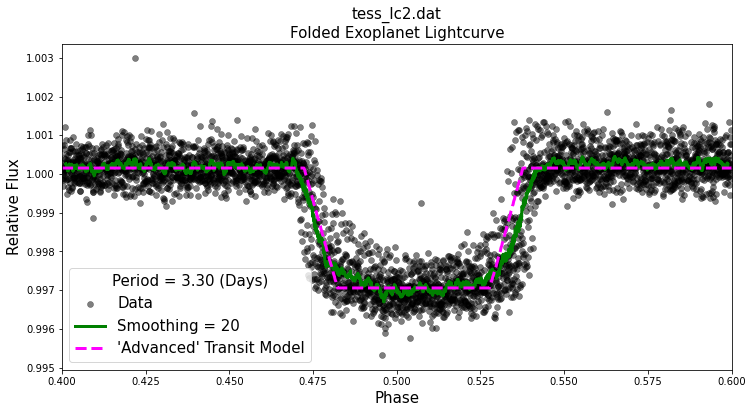

In [22]:
boxcar_length = 20
for exoplanet_data in [data_file01, data_file02]:
    period, popt, pcov = find_exoplanet(exoplanet_data, boxcar_length, make_plot=True,)

In [18]:
def transit_model(time, t_cent, dt_total, flux_avg, depth, dt_in):

    lightcurve = np.ones(len(time)) * flux_avg

    # make top hat part
    start_idx = find_nearest(time, t_cent - 0.5*dt_total)
    end_idx = find_nearest(time, t_cent + 0.5*dt_total)
    lightcurve[start_idx:end_idx] = (flux_avg - depth)
    #print(start_idx, end_idx)

    # ingress part 
    slope = ((flux_avg- depth)  - flux_avg)/ dt_in
    #print('slope is', slope)
    start_in_idx = find_nearest(time, t_cent - 0.5*dt_total - dt_in)
    end_in_idx = find_nearest(time, t_cent  - 0.5*dt_total)
    ingress_len = len(lightcurve[start_in_idx:end_in_idx])
    slope = ((flux_avg- depth)  - flux_avg) / ingress_len
    lightcurve[start_in_idx:end_in_idx] = slope* np.arange(ingress_len) + flux_avg

    # egress
    # dt_in is the same as dt_out
    
    #print('slope is', slope)
    start_eg_idx = find_nearest(time, t_cent + 0.5*dt_total)
    end_eg_idx = find_nearest(time, t_cent + 0.5*dt_total +dt_in)
    eggress_len = len(lightcurve[start_eg_idx:end_eg_idx])
    slope = ((flux_avg - (flux_avg- depth))) / eggress_len
    lightcurve[start_eg_idx:end_eg_idx] = slope* np.arange(eggress_len) + (flux_avg - depth)

    return lightcurve


def fit_transit_model(time, lightcurve, initial_guess=None, absolute_sigma=True, sigma=None):
    # Define the fitting function and initial parameter values
    popt, pcov = curve_fit(transit_model, time, lightcurve, p0=initial_guess, absolute_sigma=True, sigma=None)#po=guess)
    return popt, pcov


Text(0, 0.5, 'flux')

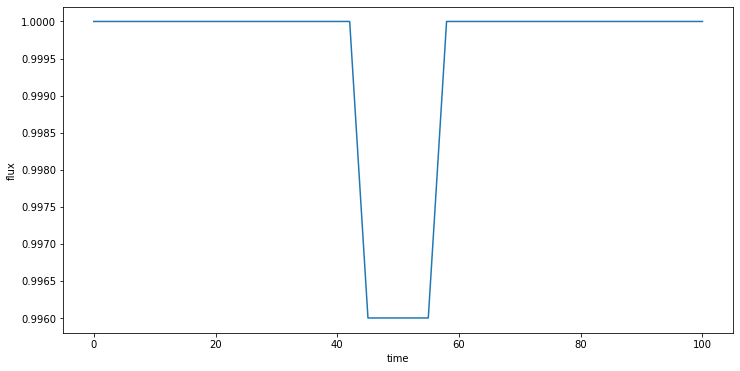

In [19]:
time = np.linspace(0,100,1000)
t_cent = 50
dt_total = 10
flux_avg = 1
depth= 1-0.996
dt_in = 3

lightcurve = transit_model(time, t_cent, dt_total, flux_avg, depth, dt_in)

plt.figure(figsize=(12,6))
plt.plot(time, lightcurve)
plt.xlabel('time')
plt.ylabel('flux')
#plt.hlines(1- depth, 0, 100, color='k')


In [ ]:
def find_period(data, smoothed_data, boxcar_length, make_plot = True, exoplanet_name = None,
                n=10000, f_min = 1/(2*720), f_max = 4):
    '''makes a periodo-gram'''



    sample_times = data[boxcar_length:-boxcar_length,0]
    time = sample_times
    flux_values = smoothed_data[boxcar_length:-boxcar_length] / np.nanmean(data[:,1])
    y = flux_values 

    f = np.linspace(f_min, f_max,  n) * day_in_hz * u.Hz
    power = LombScargle(time * u.day, y).power(frequency=f)

    frequency = f / u.Hz
    # identify peaks
    peaks, _ = find_peaks(power,height=0.03)

    if make_plot == True:
        if exoplanet_name != '':
            exoplanet_name += '\n'
        plt.figure(figsize=(12,6))
        plt.plot(frequency * day_in_s, power, label="Power Spectrum", color='firebrick')
        plt.title(exoplanet_name + 'Lomb-Scargle periodogram', size=15)
        plt.xlabel('Frequency (1/Days)', size=15)
        plt.ylabel('Power Spectrum', size=15)
        plt.plot(frequency[peaks] * day_in_s, power[peaks], "x", color='k', label='Identified Peaks')
        plt.legend(fontsize=15)

    fundemental_freq = frequency[peaks]  / u.Hz

    popt, pcov = curve_fit(fundemental_freq_model, xdata =peaks, ydata=(f[peaks])*day_in_s)


    f0 = popt[0] # the inverse of this is period
    return 1/f0




In [ ]:
from astropy.timeseries import LombScargle
import astropy.units as u


sample_times = data[20:-20,0]
new_sample_times = np.array(sample_times) 
time = new_sample_times

flux_values = smoothed_data[20:-20] / np.nanmean(data[:,1])
y = flux_values

n=10000
f = np.linspace(1/(2*720), 4,  n) * 1.15740741e-5 * u.Hz
power = LombScargle(time * u.day, y).power(frequency=f)
frequency = f / u.Hz

plt.figure(figsize=(12,6))
plt.plot(frequency * day_in_s, power, label="Power Spectrum")
plt.title('Normalized Lomb-Scargle periodogram', size=15)
plt.xlabel('Frequency (1/Day)', size=15)
plt.ylabel('Power Spectrum', size=15)


peaks, _ = find_peaks(power,height=0.03)
plt.plot(frequency[peaks] * day_in_s, power[peaks], "x", color='k', label='Identified Peaks')
plt.legend(fontsize=15)

fundemental_freq = frequency[peaks]  / u.Hz


popt, pcov = curve_fit(fundemental_freq_model, xdata =peaks, ydata=(f[peaks])*day_in_s)


f0 = popt[0]

print(f0) # days

print(f'The Exoplanet has a period of ' + str(1/f0) + ' days')


# lets fit a line! (omg this is too much )



In [ ]:
len(time_series) % period



In [ ]:
# make folded lc


def phase_plot(x, y, period, make_plot=True):
    '''Create phase-folded lightcurve of input time-series,
      returns phase-folded lightcurve. Rolls the returned lighcurve
      so that the minimum is in the middle.


      modifed version of this (from 8:06)
      https://www.youtube.com/watch?v=2EwtD3Nhazs&t=2859s&ab_channel=LSSTCDataScienceFellowship
    
    Args:
    x: ndarray
       time-like values

    y: ndarray
       flux like values

    period: float
            period to fold the data

    Returns:
    new_x, new_y: arrays corresponding to the folded lightcurve. 
                  new_x is time-like but only for a single period
                  new_y is flux like
    '''


    # folding
    phases = (x/period) % 1
    plot_order = np.argsort(phases)
    new_x = phases[plot_order]
    new_y = y[plot_order]

    # roll
    min_index = np.argmin(new_y)
    n = len(new_y) // 2 - min_index
    new_y = np.roll(new_y, n)

    # make plot
    if make_plot == True:
      plt.figure(figsize=(12,6))
      plt.ylabel("Relative Flux", size=15)
      plt.xlabel('Phase', size=15)
      plt.title('Folded Lightcurve', size=15)
      plt.scatter(new_x, new_y, linewidth=0.5, color='k', label='Data')
      plt.ylim(0.993, 1.004)
      plt.legend(fontsize=15)
      plt.show()

    return new_x, new_y

data = get_data(data_file01)
x = data[:,0]
y = data[:,1]/ np.nanmean(data[:,1])

time_folded, flux_data_folded = phase_plot(x, y, period, make_plot=True)

x = data[20:-20,0]
y = smoothed_data[20:-20]/ np.nanmean(data[:,1])

smoothed_flux_data_folded = normalized_boxcar_convolve(signal=flux_data_folded, boxcar_length=20)


smoothed_time_folded = time_folded[20:-20]
smoothed_flux_data_folded = smoothed_flux_data_folded[20:-20]


plt.figure(figsize=(12,6))
plt.ylabel("Relative Flux", size=15)
plt.xlabel('Phase', size=15)
plt.title('Folded Lightcurve', size=15)
plt.scatter(time_folded, flux_data_folded, linewidth=0.5, color='k', label='Data')
plt.plot(smoothed_time_folded, smoothed_flux_data_folded, linewidth=1, color='green', label='Smoothed')
plt.ylim(0.993, 1.004)
plt.legend(fontsize=15)
plt.show()

# this is good but we need to 'roll' the numpy array to get the dip into
# the middle (ish) area of the lightcurve, hard to fit a mi






In [ ]:
# do model fitting and plots

def advanced_top_hat_func(time, avg_flux, trans_start, trans_base_start, trans_base_end, trans_end, transit_flux):
    # Define the top hat function

    #time = time[0,:]
    
    lc = avg_flux*np.ones(len(time))

    lc[(time >= trans_base_start) & (time < trans_end)] = transit_flux

    ingress_time = trans_base_start - trans_start
    slope = (transit_flux - avg_flux) / ingress_time

    # ingress flux
    lc[(time>= trans_start) & (time < trans_base_start)] = slope*time[(time>= trans_start) & (time < trans_base_start)]+ avg_flux

    # egress flux
    lc[(time>= trans_base_end) & (time < trans_end)] = -slope*time[(time>= trans_base_end) & (time < trans_end)]+ transit_flux

   
    return lc


def fit_advanced_top_hat(time, data, initial_guess=None, absolute_sigma=True, sigma=None):
    # Define the fitting function and initial parameter values
    popt, pcov = curve_fit(advanced_top_hat_func, time, data,p0=initial_guess, absolute_sigma=True, sigma=None)#po=guess)
    return popt, pcov


def top_hat_func(x, a, b, c, d):
    # Define the top hat function

   # print('x shape', np.shape(x))
    #x = x[0,:]
    y = a*np.ones(len(x))
   # print(np.shape(y))
    y[(x >= b) & (x < c)] = d
   
    return y


# cut out the section of the lightcurve we care about

#start_idx = 0
#stop_idx = -1

time = smoothed_time_folded
data =  smoothed_flux_data_folded
# I should trim this down to focus more on the transiet, will help the model fitting

initial_guess=[1, 0.475, 0.535, 0.990]

popt, pcov = fit_top_hat(time, data=data, initial_guess=initial_guess, absolute_sigma=True, sigma=None)


#avg_flux, trans_start, trans_base_start, trans_base_end, trans_end, transit_flux)
initial_guess = [1, 0.47, 0.475, 0.53, 0.535, 0.996]
popt_ad, pcov_ad = fit_advanced_top_hat(time, data=data, initial_guess=initial_guess, absolute_sigma=True, sigma=None)


plt.figure(figsize=(12,6))
plt.scatter(time_folded, flux_data_folded, linewidth=0.5, color='k', label='Data', zorder=0)
#plt.plot(data[start_idx:stop_idx,0], smoothed_data[start_idx:stop_idx]/ np.nanmean(data[:,1]), linewidth=2, color='Green', label='Smoothed Data')
plt.ylabel("Relative Flux", size=15)
plt.xlabel('Phase', size=15)
plt.plot(time, top_hat_func(time, *popt), 'b--', label='Top Hat Model', zorder=1,linewidth=3)
plt.plot(smoothed_time_folded, smoothed_flux_data_folded, linewidth=3, color='green', label='Smoothed', zorder=0)
plt.plot(time, advanced_top_hat_func(time, *popt_ad), linestyle=':', color='magenta', label='Advanced Top Hat Model', zorder=1,linewidth=3)
plt.title('Exoplanet Lightcurve', size=15)
plt.legend(fontsize=15, loc='lower left', ) #bbox_to_anchor=(1.38, 1))
plt.xlim(.4,.6)








In [ ]:
print(fundemental_freq.value * day_in_s)

def fundemental_freq_model(n_peaks, f0,c ):

    return (np.arange(len(n_peaks)) + 1)*f0 +c

popt, pcov = curve_fit(fundemental_freq_model, xdata =peaks, ydata=(f[peaks])*day_in_s)


f0 = popt[0]

print(f0) # days

# lets fit a line! (omg this is too much )

In [ ]:
1/20

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(data[:,0], data[:,1]/ np.nanmean(data[:,1]), linewidth=0.5, color='k', label='Data')
plt.plot(data[:,0], smoothed_data/ np.nanmean(data[:,1]), linewidth=2, color='Green', label='Smoothed Data')
plt.ylabel("Relative Flux", size=15)
plt.xlabel('Julian Date – 2457000', size=15)
plt.legend(fontsize=15)
plt.xlim(1335, 1336)
plt.ylim(0.995, 1.004)

In [ ]:
len(data[:,0])

In [ ]:
print(len(data[:,0]))

In [ ]:
time = data[:,0]
(np.abs(time - 1337)).argmin()

In [ ]:



start_idx = find_nearest(array=data[:,0], value=1335)
stop_idx = find_nearest(array=data[:,0], value=1336)

In [17]:
def advanced_top_hat_func(time, avg_flux, trans_start, trans_base_start, trans_base_end, trans_end, transit_flux):
    # Define the top hat function
    
    lc = avg_flux*np.ones(len(time))

    lc[(time >= trans_base_start) & (time < trans_base_end)] = transit_flux

    ingress_time = trans_base_start - trans_start
    slope = (avg_flux - transit_flux) / ingress_time

    # ingress flux
    lc[(time>= trans_start) & (time < trans_base_start)] = slope*time[(time>= trans_start) & (time < trans_base_start)]+ avg_flux #transit_flux #avg_flux

    # egress flux
    lc[(time>= trans_base_end) & (time < trans_end)] = -slope*time[(time>= trans_base_end) & (time < trans_end)]+ transit_flux

   
    return lc


def fit_advanced_top_hat(time, data, initial_guess=None, absolute_sigma=True, sigma=None):
    # Define the fitting function and initial parameter values
    popt, pcov = curve_fit(advanced_top_hat_func, time, data,p0=initial_guess, absolute_sigma=True, sigma=None)#po=guess)
    return popt, pcov

In [ ]:
# cut out the section of the lightcurve we care about

#start_idx = 0
#stop_idx = -1

time = data[start_idx:stop_idx,0]
initial_guess=[1, 1335.2, 1335.4, 0.995]
popt, pcov = fit_top_hat(time, data=data[start_idx:stop_idx,1] / np.nanmean(data[:,1]), initial_guess=initial_guess, absolute_sigma=True, sigma=None)


#avg_flux, trans_start, trans_base_start, trans_base_end, trans_end, transit_flux)
initial_guess = [1, 1335.1, 1335.23, 1335.3, 1335.4, 0.997]
popt_ad, pcov_ad = fit_advanced_top_hat(time, data=data[start_idx:stop_idx,1] / np.nanmean(data[:,1]), initial_guess=initial_guess, absolute_sigma=True, sigma=None)


plt.figure(figsize=(12,6))
plt.scatter(data[start_idx:stop_idx,0], data[start_idx:stop_idx,1]/ np.nanmean(data[:,1]), linewidth=0.5, color='k', label='Data')
plt.plot(data[start_idx:stop_idx,0], smoothed_data[start_idx:stop_idx]/ np.nanmean(data[:,1]), linewidth=2, color='Green', label='Smoothed Data')
plt.ylabel("Relative Flux", size=15)
plt.xlabel('Julian Date – 2457000', size=15)
plt.plot(time, top_hat_func(time, *popt), 'b--', label='Top Hat Model', zorder=1,linewidth=3)
plt.plot(time, advanced_top_hat_func(time, *popt_ad), linestyle=':', color='magenta', label='Advanced Top Hat Model', zorder=1,linewidth=3)
plt.title('Exoplanet Lightcurve', size=15)
plt.legend(fontsize=15)
#plt.xlim(1335, 1336)
print(popt_ad)

In [ ]:
# perodic gram